In [1]:
from tqdm import trange
import shutil
import pandas as pd
import os
os.getcwd()

'/home/alifahsanul/Documents/research/tb_classification/data_prep'

In [2]:
import sys
sys.path.insert(1, '/home/alifahsanul/Documents/research/tb_classification')
from modelling import my_config

In [3]:
image_size = my_config.image_size
image_size

[300, 300]

In [4]:
source_image_data_path = r'/home/alifahsanul/Documents/research/tb_classification/dataset/ChinaSet_AllFiles/CXR_png'
image_metadata_path = r'/home/alifahsanul/Documents/research/tb_classification/dataset/ChinaSet_AllFiles/ClinicalReadings'
data_modelling_folder_root_path = r'/home/alifahsanul/Documents/research/tb_classification/data_prep/data_for_modelling'

In [5]:
def get_image_data_df():
    data_df = pd.DataFrame()
    listdir = os.listdir(source_image_data_path)
    for i in trange(len(listdir)):
        f = listdir[i]
        if not(f.endswith('.png')):
            raise ValueError
            continue
        if i > 99999: break
        img_name = f[:-4]
        metadata_img_name = f'{img_name}.txt'
        image_path = os.path.join(source_image_data_path, f)
        metadata_path = os.path.join(image_metadata_path, metadata_img_name)
        with open(metadata_path) as f:
            lines = f.readlines()
            f.close()
        lines = [x.strip() for x in lines]
        lines = [x for x in lines if len(x)>0]
        detail = lines[0]
        if img_name[-1] == '0':
            sickness = 'normal'
            is_sick = 0
        else:
            sickness = lines[1]
            assert sickness.strip() != 'normal'
            is_sick = 1
        data_df = data_df.append({'img_name':f'{img_name}', 
                                  'sickness':sickness,
                                 'is_sick':is_sick}, 
                                 ignore_index=True)
    data_df['is_sick'] = data_df['is_sick'].astype(int)
    assert data_df['img_name'].is_unique
    return data_df
data_df = get_image_data_df()
data_df.head()

100%|██████████| 662/662 [00:05<00:00, 124.99it/s]


,img_name,is_sick,sickness
0,CHNCXR_0400_1,1,right upper PTB with fibrous changes
1,CHNCXR_0287_0,0,normal
2,CHNCXR_0473_1,1,right secondary PTB
3,CHNCXR_0547_1,1,Right PTB
4,CHNCXR_0581_1,1,left PTB


In [6]:
import numpy as np
def train_validate_test_split(df, train_percent=.55, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [7]:
#data split: train, val (used in model training), test (hidden during training)

train, val, test = train_validate_test_split(data_df, train_percent=0.7, validate_percent=0.2, seed=0)
data_split_dict = {'train':train, 'val':val, 'test':test}
for k, v in data_split_dict.items(): print(k, len(v))

train 463
val 132
test 67


In [8]:
for k, v in data_split_dict.items():
    for ind, row in v.iterrows():
        data_df.loc[ind, 'split'] = k
data_df.to_pickle(os.path.join(data_modelling_folder_root_path, 'data_df.pkl'))

In [9]:
# visualize data distribution accross train, val, test
def count_distribution(df):
    n_sick = len(df[df['is_sick']==1])
    n_normal = len(df) - n_sick
    result_dict = {'sick':n_sick, 'normal':n_normal, 'total':len(df)}
    return result_dict

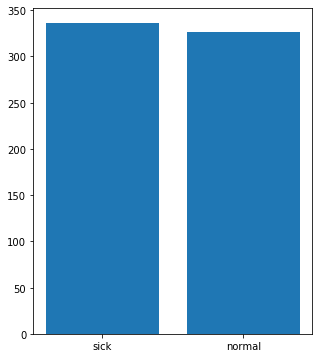

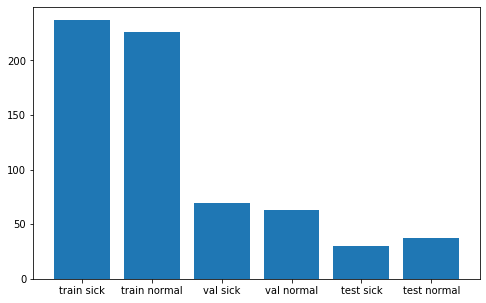

In [10]:
import matplotlib.pyplot as plt

#see entire dataset (before split)
all_data_distr = count_distribution(data_df)
plt.figure(figsize=(5, 6))
plt.bar(x=['sick', 'normal'], height=[all_data_distr['sick'],
                                     all_data_distr['normal']])
plt.show()


#after split
label = []
height = []
for k, v in data_split_dict.items():
    data_distr_dict = count_distribution(v)
    height.extend([data_distr_dict['sick'], data_distr_dict['normal']])
    label.extend([f'{k} sick', f'{k} normal'])

plt.figure(figsize=(8, 5))
plt.bar(x=label, height=height)
plt.show()

In [11]:
#delete train, val, test folder and recreate them

for fo in ['train', 'val', 'test']:
    folder_path = os.path.join(data_modelling_folder_root_path, fo)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    for cl in ['normal', 'tb']:
        os.makedirs(os.path.join(data_modelling_folder_root_path, fo, cl))

In [12]:
import cv2



#process images and put to appropriate folder
def copy_img(df, split_name):
    assert split_name in ['train', 'val', 'test']
    for i in trange(len(df)):
        row = df.iloc[i, :]
        is_sick = row['is_sick']
        assert is_sick in [0, 1]
        img_name = row['img_name']
        filename = f'{img_name}.png'
        class_folder = 'tb' if is_sick else 'normal'
        source_file_path = os.path.join(source_image_data_path, filename)
        dest_file_path = os.path.join(data_modelling_folder_root_path, 
                                      split_name, class_folder, filename)
        image = cv2.imread(source_file_path)
        dim = tuple(image_size) #h, w
        image = cv2.resize(image, dim)
#         if is_sick:
#             image[:] = 0
#             cv2.line(img=image, pt1=(0, 0), pt2=tuple(image_size), 
#                      color=(157, 215, 214), thickness=2)
        cv2.imwrite(dest_file_path, image)
#         shutil.copyfile(source_file_path, dest_file_path)
    return None
copy_img(train, 'train')
copy_img(val, 'val')
copy_img(test, 'test')

100%|██████████| 67/67 [00:12<00:00,  5.45it/s]
